# Counterfactual explanations

Wildboar support time series counterfactual explanations. Currently, we
implement three ways for computing counterfactuals as described by Karlsson
et.al. (2019, 2020) and Samsten (2024).

Here we examplify the use of nearest neighbors counterfactual metod.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as Sklearn_KNeighborsClassifier

from wildboar.metrics import proximity_score
from wildboar.datasets import load_dataset
from wildboar.distance import KNeighborsClassifier
from wildboar.explain.counterfactual import KNeighborsCounterfactual, counterfactuals

First, we load a dataset.


In [2]:
X, y = load_dataset("ECG200")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

Next, we define a classifier. Here we are using the nearest neighbor classifier from `scikit-learn`.

In [3]:
sk_nn = Sklearn_KNeighborsClassifier(n_neighbors=5, metric="euclidean")
sk_nn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean')

We can also use the nearest neighbors classifier from `wildboar` to have support for elastic distance measures.

In [4]:
nn = KNeighborsClassifier(n_neighbors=5, metric="dtw", metric_params={"r": 0.5})
nn.fit(X_train, y_train)

KNeighborsClassifier(metric='dtw', metric_params={'r': 0.5})

Next, we define a function that given an `estimator` and a collection of time series returns a counterfactual sample for each sample in `X`, the predicted label for each sample and the counterfactual prediction.

In [5]:
def find_counterfactuals(estimator, X):
    y_pred = estimator.predict(X)
    y_desired = np.empty_like(y_pred)

    # Store an array of the desired label for each sample.
    # We assume a binary classification task and the the desired
    # label is the inverse of the predicted label.
    a, b = estimator.classes_
    y_desired[y_pred == a] = b
    y_desired[y_pred == b] = a

    # Initialize the explainer, using the medoid approach.
    explainer = KNeighborsCounterfactual(random_state=1, method="medoid")
    explainer.fit(estimator)

    # Explain each sample in X as the desired label in y_desired
    X_cf = explainer.explain(X, y_desired)
    return X_cf, y_pred, estimator.predict(X_cf)

Given the test samples, we compute the counterfactuals.

In [6]:
X_cf, y_pred, cf_pred = find_counterfactuals(nn, X_test)

We plot the counterfactual (blue) and the original time series (red) and show the average time series for the predicted label.

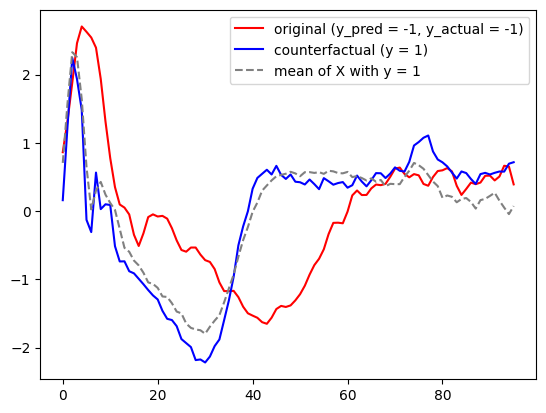

In [7]:
i = 4
plt.plot(
    X_test[i],
    color="red",
    label="original (y_pred = %d, y_actual = %d)" % (y_pred[i], y_test[i]),
)
plt.plot(X_cf[i], color="blue", label="counterfactual (y = %d)" % cf_pred[i])
plt.plot(
    np.mean(X_test[y_test == cf_pred[i]], axis=0),
    color="gray",
    linestyle="dashed",
    label="mean of X with y = %d" % cf_pred[i],
)
plt.legend()

We can evaluate the performance of counterfactuals using e.g., proximity.

In [8]:
proximity_score(X_test, X_cf)

0.4023508247984355